In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib

In [2]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
DEVICE = utils.find_device(force_cpu=False)

Using device cuda


In [5]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [6]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [7]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Sampling trajectories and evaluating them...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Sampling trajectories and evaluating them...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


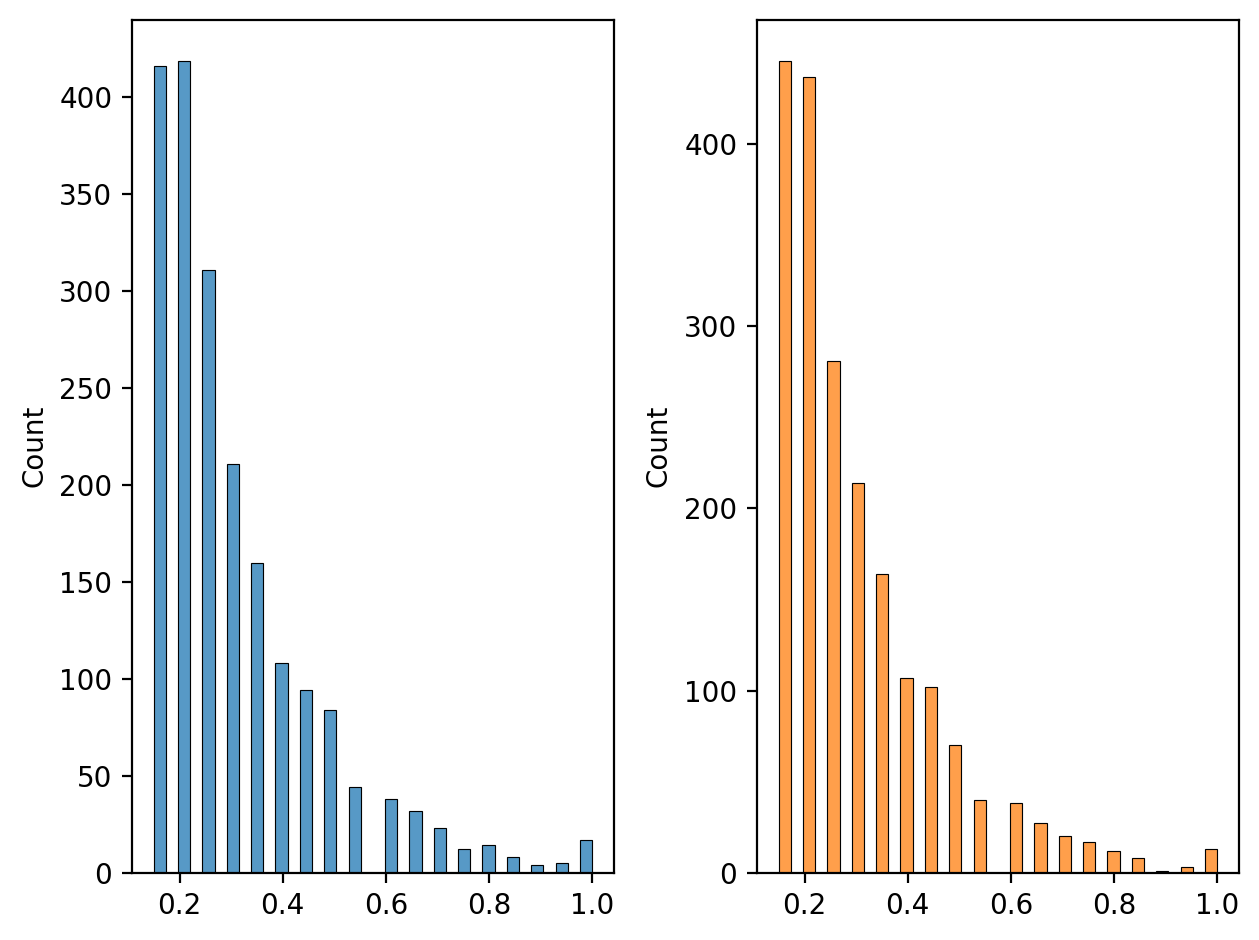

In [8]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# AE

## Defining the AE model

In [71]:
class AE(nn.Module):

    def __init__(self, time_horizon, z_dim):
        super().__init__()

        self.z_dim, self.time_horizon = z_dim, time_horizon

        # Encoder 

        self.enc = nn.Sequential(
            nn.Linear(time_horizon, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, z_dim))
        
        # Decoder 

        self.dec = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, time_horizon))

    def encode(self, x):
        x = self.enc(x)
        return x

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        z = self.encode(x)
        x = self.decode(z)
        return x

## Define Z dimensionality

In [ ]:
Z_DIM = 2

## Try the model out

In [94]:
Z_DIM = 2
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
ae = AE(time_horizon=TIME_HORIZON, z_dim=Z_DIM).to(DEVICE)
for batch_idx, (x, y) in enumerate(train_loader):
    z = ae.encode(x)
    x_rec = ae.decode(z)
    break

## Training AE

In [77]:
def eval_reconstruction(model, data_loader):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            recon_x = model(x)
            delta += torch.abs(x - recon_x).sum()

    n = len(data_loader.dataset)
    delta /= (n*model.time_horizon)
    print(f"Avg reconstruction error: {delta.item():.4f}")    

### Random level for reconstruction

In [78]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.4f} +/- {delta.std().item():.4f}")

Avg reconstruction error: 0.3325 +/- 0.2359


### Initial level of reconstruction error

In [79]:
seed = 1234
torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, z_dim=Z_DIM).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2504
Avg reconstruction error: 0.2502


### Training loop

In [87]:
seed = 1234
size_z = 2
lr = 0.01
batch_size = len(train_dataset.y)
n_epoch = 5000

torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, z_dim=Z_DIM).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

optimizer = optim.Adam(list(ae.parameters()), lr=lr) # + list(reg.parameters()), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        epoch_loss = 0 
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()
            recon_x = ae(x)
            loss = nn.MSELoss(reduction="mean")(target=x, input=recon_x)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        hist_loss.append(epoch_loss/len(train_loader))

        pbar.update()
        pbar.set_postfix(loss=f"{hist_loss[-1]:.5f}")

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2504
Avg reconstruction error: 0.2502


  0%|          | 0/5000 [00:00<?, ?it/s]

Avg reconstruction error: 0.1503
Avg reconstruction error: 0.2629


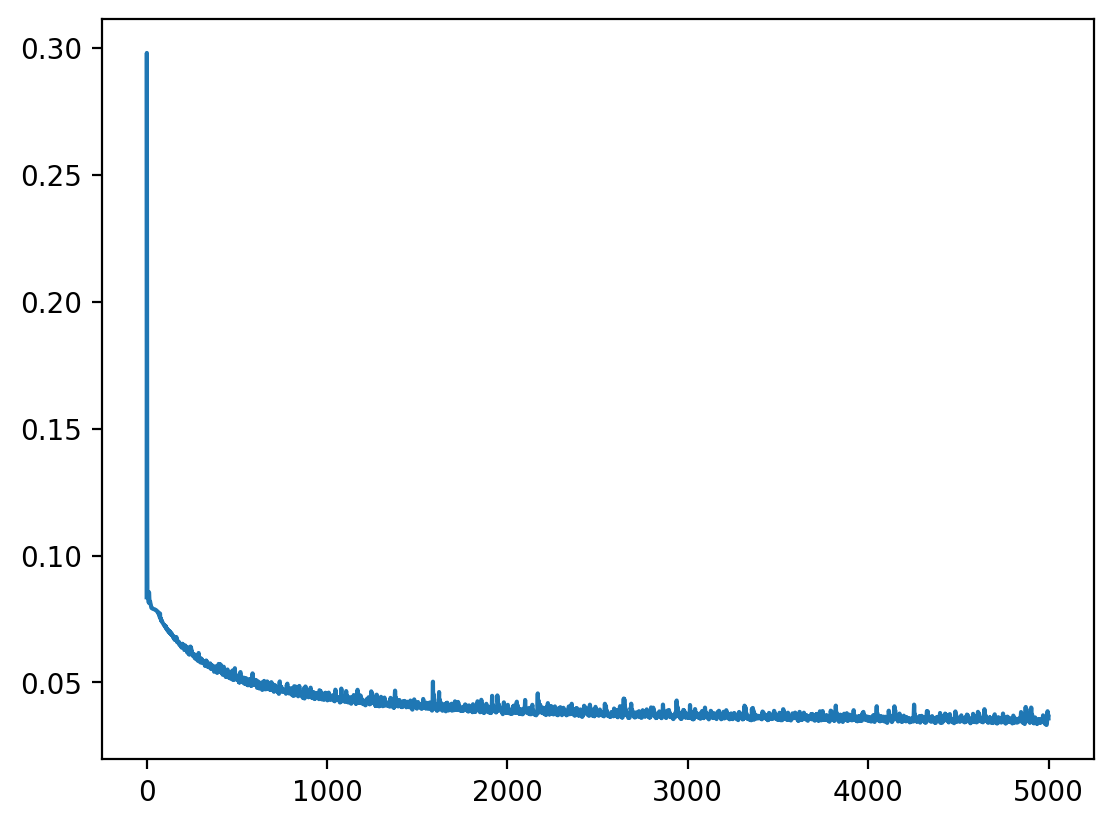

In [88]:
plt.plot(hist_loss);

In [89]:
eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.1503
Avg reconstruction error: 0.2629


## Visualize structuration of the latent space

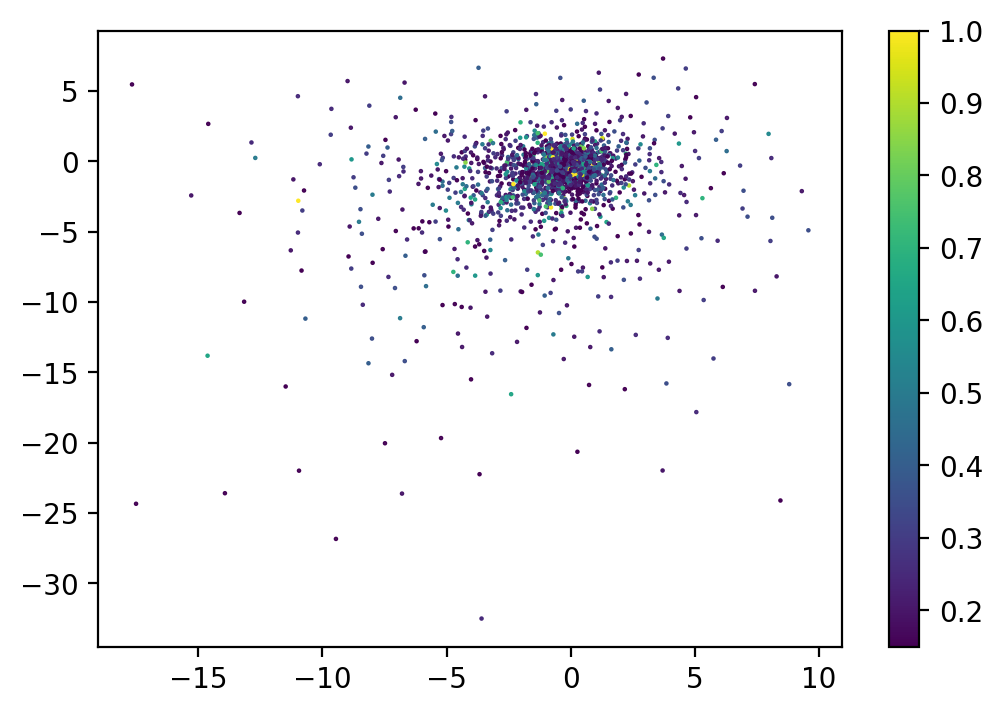

In [92]:
ae.eval()
x, y = train_dataset.x, train_dataset.y
with torch.no_grad():
    z = ae.encode(x)
    z = z.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    marker='o', s=0.4
    # vmin=0.0, vmax=1.0,
)

plt.colorbar(im);